In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tiktoken

In [2]:
GPT_CONFIG_124M = {
    'vocab_size': 50257, 
    'context_length': 1024,
    'emb_dim': 768,
    'n_heads': 12, 
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
}

In [3]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cnf):
        super().__init__()
    
    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    
    def forward(self, x):
        return x

class DummyGPTModel(nn.Module):
    def __init__(self, cnf):
        super().__init__()
        self.tok_emb = nn.Embedding(cnf['vocab_size'], cnf['emb_dim'])
        self.pos_emb = nn.Embedding(cnf['context_length'], cnf['emb_dim'])
        self.drop_emb = nn.Dropout(cnf['drop_rate'])
        
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cnf) for _ in range(cnf['n_layers'])])
        
        self.final_norm = DummyLayerNorm(cnf['emb_dim'])
        self.out_head = nn.Linear(cnf['emb_dim'], cnf['vocab_size'], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits     

In [4]:
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

tokenizer = tiktoken.get_encoding('gpt2')
batch = []
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch)
print(batch.shape)
print(batch)

torch.Size([2, 4])
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(logits.shape)
print(logits)

torch.Size([2, 4, 50257])
tensor([[[ 2.0113e+00, -1.6912e+00, -4.6529e-01,  ...,  1.0910e+00,
           1.0955e+00,  1.0168e+00],
         [-1.5347e+00,  4.2393e-01, -1.5320e-01,  ...,  6.0008e-02,
          -1.5565e+00,  4.2410e-01],
         [-4.6195e-01,  8.2180e-02, -3.0672e-01,  ..., -1.1269e-01,
           3.9272e-01, -3.3959e-01],
         [ 1.6058e-01, -1.4028e-01, -1.0685e+00,  ...,  4.3382e-01,
          -9.5977e-01, -5.8908e-01]],

        [[ 1.7767e+00, -1.2756e+00, -1.0796e+00,  ...,  1.0693e+00,
           6.6166e-01,  1.0350e+00],
         [-2.0482e+00, -1.8384e-01, -7.7564e-01,  ..., -1.0486e-01,
          -7.3675e-01,  1.8347e+00],
         [-1.6256e-01, -1.7549e+00,  1.0772e-01,  ...,  1.6144e+00,
           2.7656e+00,  2.0306e-01],
         [ 8.5153e-01,  1.2562e-03,  5.6551e-01,  ..., -8.2689e-01,
          -5.9384e-01, -1.6443e+00]]], grad_fn=<UnsafeViewBackward0>)


In [6]:
batch_example = torch.randn(2, 5)
m = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
o = m(batch_example)
print(o)

tensor([[0.2252, 0.6265, 0.0851, 0.0000, 0.0181, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.1146, 1.1043]],
       grad_fn=<ReluBackward0>)


In [7]:
mean = o.mean(dim=-1, keepdims=True)
var = o.std(dim=-1, keepdims=True)
print(mean)
print(var)

tensor([[0.1592],
        [0.3698]], grad_fn=<MeanBackward1>)
tensor([[0.2445],
        [0.5729]], grad_fn=<StdBackward0>)


In [8]:
torch.set_printoptions(sci_mode=False)
o_normalized = (o-mean)/torch.sqrt(var)
o_mean = o_normalized.mean(dim=-1, keepdim=True)
o_var = o_normalized.var(dim=-1, keepdim=True)
print(o_mean)
print(o_var)

tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[0.2445],
        [0.5729]], grad_fn=<VarBackward0>)


In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x-mean)/torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift   
        
        

In [10]:
ln = LayerNorm(5)
o_ln = ln(batch_example)


In [11]:
mean = o_ln.mean(-1, keepdim=True)
var = o_ln.var(-1, unbiased=False, keepdim=True)
print('mean', mean)
print('var', var)

mean tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
var tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [51]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

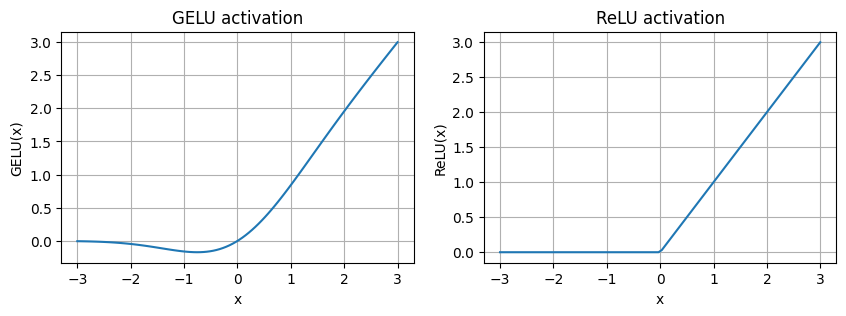

In [30]:
glue, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_glue, y_relu = glue(x), relu(x)

plt.figure(figsize=(10, 3))
for i, (y, label) in enumerate(zip([y_glue, y_relu], ['GELU', 'ReLU']), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel(f'{label}(x)')
    plt.grid(True)
    plt.title(f'{label} activation')

In [52]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']), 
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)

In [53]:
ffn = FeedForward(GPT_CONFIG_124M)
x  = torch.rand(2, 3, GPT_CONFIG_124M['emb_dim'])
o = ffn(x)
print(o.shape)

torch.Size([2, 3, 768])


In [66]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[i-1], layer_sizes[i]), GELU()) for i in range(1, len(layer_sizes))
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [67]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [72]:
layer_sizes = [3, 3, 3, 3, 3, 1] 
m =  ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
torch.manual_seed(123)
sample_input = torch.tensor([[1., 0., -1.]])
print_gradients(m, sample_input)

layers.0.0.weight has gradient mean of 7.809203816577792e-05
layers.1.0.weight has gradient mean of 0.00010268267942592502
layers.2.0.weight has gradient mean of 0.000554734724573791
layers.3.0.weight has gradient mean of 0.0015046836342662573
layers.4.0.weight has gradient mean of 0.008380373008549213


In [73]:
m =  ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(m, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.3289699852466583
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472
